# Gender and Testimony - Extracting Language Patterns with spaCy

### Before We Begin . . .

This Notebook expects you to have reviewed [Lauren Klein's](https://github.com/laurenfklein/emory-qtm340/blob/master/notebooks/class11-nlp-spacy-complete.ipynb) "crash course" introduction to natural language processing (NLP). If you have never used spaCy before or are unfamiliar with basic linguistic concepts it is encouraged that you first scroll down to the section "Installing and Importing spaCy" (in this Notebook) for installation directions and then work through Klein's Notebook before continuing.

### The Ongoing Problem of Data-Driven Text Analysis

The process of extracting meaningful language patterns poses underlying challenges for any data-driven textual analysis. Here, this challenge is imagined as two-fold: analysts must determine which patterns are "meaningful" and analysts must apply the appropriate methods and tools to extract these meaningful patterns.

Determining which patterns are meaningful might not be immediately clear when working with an unfamiliar corpus, or when working with a familiar corpus that has complexities beyond what we thought we knew. Noticing new patterns or ideas is a common experience when re-reading a familiar text through a different angle.

Deciding which language patterns are meaningful should therefore be a critical, iterative process. We must ask guiding questions and also evaluate the efficacy of these questions. What kinds of rabbit holes do our questions lead us down? Are there risks involved in the way we ask questions--risks such as distorting the subject matter at hand in order to confirm our own biases?

Analysts must also match guiding questions with an appropriate technique while being mindful that the methods and tools used to measure a corpus also give shape to the corpus and our analysis.

The purpose of this Notebook is to engage with this two-fold problem while text mining with spaCy NLP. In this exercise we will algorithmically read the 1870 Hansard debates with the purpose of analyzing word co-occurance of grammatical gendered pronoun-verb pairs. These pairs are not necessarily consecutive, like bigrams, but instead share syntactic relations in a sentence.

To explore how technique and analysis go hand-in-hand, this Notebook will ask a high-level, guiding question about gender: what kinds of actions are associated with male and female pronouns in 1870? 

### Why spaCy?

spaCy is a comprehensive, industrial-grade software library for natural language processing (NLP). It provides tools to extract language patterns. From a linguistic standpoint, spaCy outperforms popular tools like NLTK because spaCy offers advanced statistical language models from which it parses and tags words.

spaCy's NLP pipeline is shown below. Provided with text, spaCy can tokenize, tag, parse, perform named entity recognition, and more. 

The pipeline returns a parsed `Doc` object.

<img src="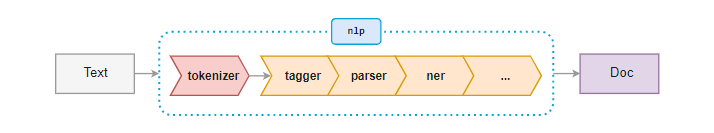
">

spaCy's [linguistic features](https://spacy.io/usage/linguistic-features) include:

#### 1. Syntactic dependency parsing

Syntax is the ordering from which words derive meaning within a sentence. After parsing words' syntactic dependencies, analysts can reconstruct grammatical rules for the purpose of extracting parts-of-speech.

#### 2. Part-of-speech tagging

Parts-of-speech are lexical categories that corresponds with a word's syntactic function--categories like "adjective" or "verb." spaCy tags parts-of-speech using a statistical model to predict which tag should most likely appear in a given context. 

#### 3. Rule-based morphology

Morphology refers to word form and how different forms relate to other words in a sentence. Consider the verbs "write" and "writing" in the following sentences: 

    "I write programs."
    "I am writing a program."

The later is called an inflectional form. It is important to note that inflectional forms do not change a word's part-of-speech.

Morphology is important to the process of lemmatization, or transforming words to their base form. Lemmatizing words before measuring them can streamline our results so words like "rent" and "rented" are not counted separately.

#### 4. Tokenization

Tokenization is the process of splitting texts into meaningful segments like n-grams. spaCy has tokenization support for over [59 languages](https://spacy.io/usage/models).

#### 5. Entity Extraction

spaCy offers entity recognition for a variety of named and numeric entities including locations, person names, and organizations. Users can also add their own classes of entities.

### Installing and Importing spaCy

Despite how the names "spaCy" and "Jupyter" seem to suggest they were brewed together in a Python sci-fi themed lab, spaCy is not native to Jupyter's Conda environment. spaCy can be installed on the command line or by running a Shell command in Jupyter. To run Shell commands in Jupyter use `!` followed by the command you wish to execute.

The following code installs spaCy and downloads the English language model.

In [ ]:
!pip install -U spacy

In [ ]:
!python -m spacy download en

<div class="alert alert-block alert-info">
<b>Note:</b> Windows users should run Jupyter as administrator to install spaCy. To run Jupyter as administrator, type "Anaconda Navigator" in Search and right click "run as administrator."
</div>

spaCy can be imported after installation.

In [1]:
import spacy, warnings; warnings.simplefilter('ignore')

The language model can be loaded with `spacy.load()`. `spacy.load()` returns a `Language` object with the components and data required to process text such as a tagger and a tokenizer. 

For convention's-sake we will call our `Language` object `nlp`.

In [2]:
nlp = spacy.load('en')

<div class="alert alert-block alert-info">
<b>Note:</b> Running dir(nlp) will return the object's attributes.
</div>

Now we need the data we wish to analyze. We can use the same data from last code exercise to compare how our approach to mining changes our perspective of the Hansard data.

### Loading the Hansard data

<div class="alert alert-block alert-info">
<b>Note:</b> The metadata for this Notebook is located on M2 at `/scratch/group/pract-text-mine/digital-history`.
</div>

pandas offers methods to read the Hansard data.

In [5]:
import pandas as pd

hansard = pd.read_csv('hansard_1870_79.csv')

In [6]:
hansard

,sentence_id,speechdate,debate,text,speaker
0,S3V0199P0_0,1870-02-08,THE QUEEN'S SPEECH.,delivered HER MAJESTY'S SPEECH to both Houses ...,THE LORD CHANCELLOR
1,S3V0199P0_1,1870-02-08,THE QUEEN'S SPEECH— ADDRESS IN ANSWER TO HER M...,"My Lords, I rise to move that a humble Address...",THE MARQUESS OF HUNTLY
2,S3V0199P0_2,1870-02-08,THE QUEEN'S SPEECH— ADDRESS IN ANSWER TO HER M...,I venture to ask your Lordships' indulgence in...,THE MARQUESS OF HUNTLY
3,S3V0199P0_3,1870-02-08,THE QUEEN'S SPEECH— ADDRESS IN ANSWER TO HER M...,I trust that any errors I may be guilty of may...,THE MARQUESS OF HUNTLY
4,S3V0199P0_4,1870-02-08,THE QUEEN'S SPEECH— ADDRESS IN ANSWER TO HER M...,I am sure your Lordships will have heard with ...,THE MARQUESS OF HUNTLY
...,...,...,...,...,...
1130415,S3V0249P0_13044,1879-08-15,ROYAL COMMISSIONS—REPORTS AND EVIDENCE. —QUEST...,Gentleman may be assured that no undue partial...,MR. GOSCHEN
1130416,S3V0249P0_13045,1879-08-15,OFFENSIVE PRINTS. —QUESTION.,asked the Secretary of State for the Home De- ...,SIR PATRICK O'BRIEN
1130417,S3V0249P0_13046,1879-08-15,OFFENSIVE PRINTS. —QUESTION.,"Sir, in reference to a reply which I recently ...",MR. ASSHETON CROSS
1130418,S3V0249P0_13047,1879-08-15,OFFENSIVE PRINTS. —QUESTION.,I do not retract anything that I said on a for...,MR. ASSHETON CROSS


### Parsing Text with spaCy

As demonstrated in [Klein's Notebook](https://github.com/laurenfklein/emory-qtm340/blob/master/notebooks/class11-nlp-spacy-complete.ipynb), invoking `nlp` on a string of text will return a processed `Doc` object. Within each `Doc` object is a spaCy `token` object. From these `token` objects we can access a word's lemmatized form, its part-of-speech, and other attributes.

Unlike Klein's data, however, ours is in a data frame where each row is a string of text. To use `.nlp()` we must iteratate through each row of the data frame.

A standard way to iterate in Python is with `.apply()`, such as in the example: `dataframe['parsed_text'] = dataframe['text'].apply(nlp)`. spaCy, however, offers highly optimized tools to improve parsing time. For example, `nlp.pipe()` is more efficient because it processes the data in a stream where it is processed in small batches instead of all at once. To improve parsing time we can also disable features that we will not use for this exercise like named entity recognition, or `ent`.

Keep in mind, however, that `nlp.pipe()` returns a `generator` object that yields `Doc` objects. To interact with the data as usual we must cast the `generator` objects to a list.

<div class="alert alert-block alert-info">
<b>Note:</b> The following code returns a large data set (~30G). If you are running this Notebook on a personal computer (instead of M2) then before invoking `nlp.pipe()` consider filtering the data for just sentences with gendered pronouns or subsetting the data for just the `text` column.

In [7]:
hansard['parsed_text'] = list(nlp.pipe(hansard['text'], disable = ["ent"]))

In [8]:
hansard

,sentence_id,speechdate,debate,text,speaker,parsed_text
0,S3V0199P0_0,1870-02-08,THE QUEEN'S SPEECH.,delivered HER MAJESTY'S SPEECH to both Houses ...,THE LORD CHANCELLOR,"(delivered, HER, MAJESTY, 'S, SPEECH, to, both..."
1,S3V0199P0_1,1870-02-08,THE QUEEN'S SPEECH— ADDRESS IN ANSWER TO HER M...,"My Lords, I rise to move that a humble Address...",THE MARQUESS OF HUNTLY,"(My, Lords, ,, I, rise, to, move, that, a, hum..."
2,S3V0199P0_2,1870-02-08,THE QUEEN'S SPEECH— ADDRESS IN ANSWER TO HER M...,I venture to ask your Lordships' indulgence in...,THE MARQUESS OF HUNTLY,"(I, venture, to, ask, your, Lordships, ', indu..."
3,S3V0199P0_3,1870-02-08,THE QUEEN'S SPEECH— ADDRESS IN ANSWER TO HER M...,I trust that any errors I may be guilty of may...,THE MARQUESS OF HUNTLY,"(I, trust, that, any, errors, I, may, be, guil..."
4,S3V0199P0_4,1870-02-08,THE QUEEN'S SPEECH— ADDRESS IN ANSWER TO HER M...,I am sure your Lordships will have heard with ...,THE MARQUESS OF HUNTLY,"(I, am, sure, your, Lordships, will, have, hea..."
...,...,...,...,...,...,...
1130415,S3V0249P0_13044,1879-08-15,ROYAL COMMISSIONS—REPORTS AND EVIDENCE. —QUEST...,Gentleman may be assured that no undue partial...,MR. GOSCHEN,"(Gentleman, may, be, assured, that, no, undue,..."
1130416,S3V0249P0_13045,1879-08-15,OFFENSIVE PRINTS. —QUESTION.,asked the Secretary of State for the Home De- ...,SIR PATRICK O'BRIEN,"(asked, the, Secretary, of, State, for, the, H..."
1130417,S3V0249P0_13046,1879-08-15,OFFENSIVE PRINTS. —QUESTION.,"Sir, in reference to a reply which I recently ...",MR. ASSHETON CROSS,"(Sir, ,, in, reference, to, a, reply, which, I..."
1130418,S3V0249P0_13047,1879-08-15,OFFENSIVE PRINTS. —QUESTION.,I do not retract anything that I said on a for...,MR. ASSHETON CROSS,"(I, do, not, retract, anything, that, I, said,..."


`sampled_data` is a data frame with the following columns:

 - `sentence_ID`: A unique identifier
 - `speechdate`: the date of the debate
 - `text`: the original debate text split into one sentence per row.
 - `parsed_text`: the parsed debate text where every tuple is spaCy `doc` object containing spacy `token` objects

### Processing spaCy `token` Object Attributes for Part-of-Speech Extraction

For our analysis, we are just interested in the spaCy `token` objects. The `token` objects include attributes such as:

 - `.text`: the original word
 - `.lemma_`: the word's lemmatized form
 - `.pos_`: the word's part-of-speech
 - `.dep_`: the word's syntactic dependency
 - `.head.text`: the text upon which the present word is dependent

These attributes can be viewed by iterating through each `doc` object like the following code:

In [9]:
def extractTokens(spacy_doc_object):
    spacy_tokens = []
    for doc in spacy_doc_object['parsed_text']:
        for token in doc:
            row = (token.text, token.lemma_, token.pos_, token.dep_, token.head.text)
            spacy_tokens.append(row)
    return spacy_tokens

hansard_tokens = extractTokens(hansard)

In [10]:
hansard_tokens[:30]

[('delivered', 'deliver', 'VERB', 'ROOT', 'delivered'),
 ('HER', 'her', 'DET', 'poss', 'MAJESTY'),
 ('MAJESTY', 'MAJESTY', 'PROPN', 'poss', 'SPEECH'),
 ("'S", "'s", 'PART', 'case', 'MAJESTY'),
 ('SPEECH', 'speech', 'NOUN', 'dobj', 'delivered'),
 ('to', 'to', 'ADP', 'prep', 'delivered'),
 ('both', 'both', 'DET', 'det', 'Houses'),
 ('Houses', 'Houses', 'PROPN', 'pobj', 'to'),
 ('of', 'of', 'ADP', 'prep', 'Houses'),
 ('Parliament', 'Parliament', 'PROPN', 'pobj', 'of'),
 (',', ',', 'PUNCT', 'punct', 'delivered'),
 ('as', 'as', 'SCONJ', 'mark', 'follows'),
 ('follows', 'follow', 'VERB', 'advcl', 'delivered'),
 (':', ':', 'PUNCT', 'punct', 'delivered'),
 ('—', '—', 'PUNCT', 'punct', 'delivered'),
 ('My', '-PRON-', 'DET', 'poss', 'Lords'),
 ('Lords', 'Lords', 'PROPN', 'npadvmod', 'rise'),
 (',', ',', 'PUNCT', 'punct', 'rise'),
 ('I', '-PRON-', 'PRON', 'nsubj', 'rise'),
 ('rise', 'rise', 'VERB', 'ROOT', 'rise'),
 ('to', 'to', 'PART', 'aux', 'move'),
 ('move', 'move', 'VERB', 'advcl', 'rise'),


<div class="alert alert-block alert-info">
<b>Note:</b> NLP's entire list of attributes can be viewed with `dir()`.
</div>

Sentences can be distilled into parts-of-speech that syntactically relate. These parts-of-speech can be aggregated to see language trends that are difficult or impossible to perceive as a human interpreter.

The following code extracts grammatical pairs where the subject is tagged as a noun subject or passive noun subject and is also a child of a verb.

The verb is lemmatized to prevent counting inflectional verbs separately from their base form.

In [11]:
from spacy.symbols import nsubj, nsubjpass, VERB

def extractPairs(spacy_doc_object):
    pairs = []
    for doc in spacy_doc_object['parsed_text']:
        for subject in doc:
            if subject.dep == nsubj or subject.dep == nsubjpass and subject.head.pos == VERB:
                extracted_pairs = subject.text, subject.head.lemma_
                test = ' '.join(extracted_pairs)
                pairs.append(str(test))
    return pairs

pairs = extractPairs(hansard)

In [12]:
pairs[:30]

['I rise',
 'Address present',
 'I venture',
 'I undertake',
 'I trust',
 'errors lay',
 'I be',
 'Lordships look',
 'I be',
 'Lordships hear',
 'I be',
 'she suffer',
 'which make',
 'it impossible',
 'her execute',
 'relations be',
 'It be',
 'words refer',
 'which lead',
 'it be',
 'I regret',
 'settlement ratify',
 'which agree',
 'differences receive',
 'it be',
 'they adjust',
 'it gratify',
 'feeling exist',
 'it be',
 'countries be']

`pairs` is a list of strings in which the first element of each string is a subject followed by a verb. 

We can narrow these results to just strings containing gendered pronouns for the purpose of exploring our guiding question: what kinds of actions are associated with male and female pronouns in 1870?

### Filtering for Gendered Pronoun-Verb Pairs

For the sake of counting and matching with words regardless of case, we can transform all words to upper case.

In [13]:
lowercase_pairs = [word.lower() for word in pairs]

In [14]:
lowercase_pairs[:30]

['i rise',
 'address present',
 'i venture',
 'i undertake',
 'i trust',
 'errors lay',
 'i be',
 'lordships look',
 'i be',
 'lordships hear',
 'i be',
 'she suffer',
 'which make',
 'it impossible',
 'her execute',
 'relations be',
 'it be',
 'words refer',
 'which lead',
 'it be',
 'i regret',
 'settlement ratify',
 'which agree',
 'differences receive',
 'it be',
 'they adjust',
 'it gratify',
 'feeling exist',
 'it be',
 'countries be']

<div class="alert alert-block alert-info">
<b>Note:</b> Remember to capitalize I before turning in your paper.
</div>

The goal of our code exercise is to analyze through comparison gendered pronoun-verb pairs. But, first we will just extract pairs with the pronoun he.

We can search for he and its grammatical verbs by treating he as a regular expression.

The following code defines our our regular expression ('he ') and creates a variable with each pair that matches.

In [15]:
import re

def extractMalePairs(pairs):
    regex = re.compile('he ')
    male = [word for word in lowercase_pairs if regex.match(word)]
    return male

male = extractMalePairs(lowercase_pairs)

In [16]:
male[:30]

['he show',
 'he refer',
 'he think',
 'he wish',
 'he say',
 'he identify',
 'he venture',
 'he have',
 'he refuse',
 'he refuse',
 'he be',
 'he reply',
 'he do',
 'he allow',
 'he ask',
 'he shoot',
 'he be',
 'he say',
 'he argue',
 'he say',
 'he band',
 'he address',
 'he be',
 'he desire',
 'he overthrow',
 'he overthrow',
 'he overthrow',
 'he be',
 'he make',
 'he become']

Viewing just the first 30 lines of our lists has shown us that our gendered pronoun-verb pairs contain stop words like be or see. Pairs containing a stop word can be removed. 

We can do this by first defining our stop words:

In [17]:
stopwords = ['right', 'hon', 'general', 'mr', 'shall', 'majesty', 'exchequer', 'address', 'motion', 'bill',
             'earl', 'friend', 'chancellor', 'sense', 'object', 'suppose', 'amidst', 'noble', 'lord', 'agree',
             'speech', 'kind', 'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september',
             'october', 'november', 'december', 'order', 'held', 'hold', 'assembly', '£', 'humble', 'about', 'above',
             'across', 'address', 'after', 'afterwards', 'again', 'against', 'agree', 'all', 'almost', 'alone', 'along',
             'already', 'also', 'although', 'always', 'am', 'amidst', 'among', 'amongst', 'amount', 'an', 'and', 'another',
             'any', 'anyhow', 'anything', 'anyway', 'anywhere', 'april', 'are', 'around', 'as', 'at', 'back', 'be', 'was',
             'becames', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being',
             'beside', 'besides', 'between', 'beyond', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'do',
             'could', 'did', 'does', 'doing', 'done', 'down', 'due', 'during', 'each', 'either', 'else', 'elsewhere',
             'empty', 'enough', 'even', 'ever', 'everyone', 'everything', 'everywhere', 'except', 'few', 'first', 'for',
             'from', 'front', 'full', 'further', 'general', 'get', 'give', 'go', 'had', 'has', 'have', 'held', 'hence',
             'here', 'hereby', 'herein', 'hold', 'however', 'if', 'in', 'indeed', 'into', 'is', 'it', 'its', 'itself',
             'just', 'keep', 'kind', 'last', 'latter', 'least', 'less', 'made', 'make', 'many', 'me', 'meanwhile', 'might',
             'mine', 'more', 'most', 'mostly', 'move', 'much', 'must', 'name,' 'neither', 'never', 'nevertheless', 'next',
             'no', 'noble', 'nobody', 'none', 'nor', 'nothing', 'now', 'nowhere', 'of', 'off', 'often', 'on', 'one', 'once',
             'only', 'onto', 'or', 'other', 'others', 'otherwise', 'out', 'over', 'own', 'part', 'perhaps', 'please', 'put',
             'quite', 'rather', 'really', 'regarding', 'same', 'say', 'see', 'seem', 'seemed', 'seeming', 'seems', 'sense',
             'several', 'shall', 'should', 'show', 'side', 'since', 'so', 'some', 'someone', 'something', 'sometime',
             'still', 'such', 'suppose', 'take', 'than', 'that', 'the', 'then', 'there', 'thereby', 'therefore', 'these',
             'they', 'this', 'those', 'though', 'thus', 'to', 'together', 'too', 'top', 'toward', 'towards', 'under',
             'unless', 'until', 'up', 'upon', 'us', 'used', 'using', 'various', 'very', 'was', 'we', 'well', 'were', 'what',
             'whatever', 'when', 'when', 'whereby', 'whether', 'which', 'while', 'who', 'why', 'will', 'with', 'within',
             'without', 'would', 'yet', 'bright', 'mr.', 'hansard', 'lancashire', '[]', '£1', '000', 'russell', 'committee',
             'reading', 'learned', 'deal', 'time', 'royal', 'gentlemen', 'gentleman', 'year', 'years', 'affairs', 'affair',
             'academy', 'sir', 'thought', 'took', 'bring', 'brings', 'brought', 'forward', 'great', 'good', 'department',
             'treasury', 'second', 'take', 'taken', 'privy', 'member', 'robert', 'large', 'session', 'secretary', 'notice',
             'moment', 'think', 'believe', 'hope', 'ask', 'hear', 'beg', 'support', 'state', 'find', 'admit', 'wish',
             'refer', 'reply', 'know', 'feel', 'propose', 'understand', 'let', 'allow', 'like', 'receive', 'consider',
             'begin', 'tell', 'like', 'send', 'ought', 'come', 'intend', 'add', 'want', 'stand', 'suggest', 'remind',
             'use', 'mean', 'suggest']

After defining our stop words we can iterate through each pair and split the pair into individual tokens. Tokens that do not match stop words are kept while those matching a stop word are discarded.

After filtering for stop words the individual tokens are concatenated. If the remaining string is no longer a pair (i.e. has the length of two elements) the token is discarded.

In [18]:
def removeStopWords(pairs):
    keep_pairs = []
    for pair in pairs:
        tokens = pair.split(" ")
        tokens_filtered = [word for word in tokens if not word in stopwords]
        tokens_joined = "".join(tokens_filtered)
        if len(tokens_filtered) == 2:
            keep_pairs.append(str(tokens_filtered))
    return keep_pairs

male_no_stopwords = removeStopWords(male)

In [19]:
male_no_stopwords[:30]

["['he', 'identify']",
 "['he', 'venture']",
 "['he', 'refuse']",
 "['he', 'refuse']",
 "['he', 'shoot']",
 "['he', 'argue']",
 "['he', 'band']",
 "['he', 'desire']",
 "['he', 'overthrow']",
 "['he', 'overthrow']",
 "['he', 'overthrow']",
 "['he', 'acknowledge']",
 "['he', 'shoot']",
 "['he', 'preach']",
 "['he', 'protest']",
 "['he', 'remonstrate']",
 "['he', 'dismiss']",
 "['he', 'frankly']",
 "['he', 'remove']",
 "['he', 'proceed']",
 "['he', 'request']",
 "['he', 'adopt']",
 "['he', 'oblige']",
 "['he', 'dismiss']",
 "['he', 'condemn']",
 "['he', 'express']",
 "['he', 'arrive']",
 "['he', 'write']",
 "['he', 'venture']",
 "['he', 'preside']"]

<div class="alert alert-block alert-info">
<b>Note:</b> `uppercase_pairs` contains all subject-verb pairs. Before continuing, feel free to experiment by searching for any keyword of your choice.
</div>

### Counting Gendered Pronoun-Verb Pairs

After aggregating gendered pronouns that syntactically depend on a verb, we can count the frequency of each pair.

The following code defines a function, `countWords()`, that creates a dictionary of every unique pair and its frequency. Any pair not already in the dictionary is added. If the pair is already part of the dictionary its count increments by 1.

In [20]:
def countWords(clean_data):
    ngrams_dict = {}
    for ngram in clean_data:
        if ngram in ngrams_dict:
            ngrams_dict[ngram] += 1
        else:
            ngrams_dict[ngram] = 1
    return ngrams_dict
            
male_dictionary = countWords(male_no_stopwords)

In [39]:
for kv in list(male_dictionary)[:30]:
    print(kv,  male_dictionary[kv])

['he', 'identify'] 14
['he', 'venture'] 2733
['he', 'refuse'] 376
['he', 'shoot'] 41
['he', 'argue'] 230
['he', 'band'] 2
['he', 'desire'] 2594
['he', 'overthrow'] 5
['he', 'acknowledge'] 244
['he', 'preach'] 20
['he', 'protest'] 889
['he', 'remonstrate'] 11
['he', 'dismiss'] 113
['he', 'frankly'] 1
['he', 'remove'] 140
['he', 'proceed'] 471
['he', 'request'] 152
['he', 'adopt'] 445
['he', 'oblige'] 568
['he', 'condemn'] 176
['he', 'express'] 1539
['he', 'arrive'] 309
['he', 'write'] 504
['he', 'preside'] 121
['he', 'mistake'] 65
['he', 'resort'] 37
['he', 'deny'] 1384
['he', 'remark'] 508
['he', 'terrify'] 4
['he', 'witness'] 72


Dictionaries do not store their data in sequential order. This is because a dictionary is hashable, not just linear like a list. While this makes dictionaries quick to process, its organization is not conducive to analysis.

Therefore, we will cast the pronoun-verb pairs and their counts to a pandas data frame.

In [22]:
male_pronoun_verb_counts = pd.DataFrame(list(male_dictionary.items()),columns = ['Pair','Count']) # do I need list

In [23]:
male_pronoun_verb_counts

,Pair,Count
0,"['he', 'identify']",14
1,"['he', 'venture']",2733
2,"['he', 'refuse']",376
3,"['he', 'shoot']",41
4,"['he', 'argue']",230
...,...,...
2698,"['he', 'equitable']",1
2699,"['he', 'damnify']",1
2700,"['he', 'muse']",1
2701,"['he', 'excise']",1


After creating a pandas DataFrame with our pronoun-verb pairs we can arrange the frequency counts so pairs with the highest count are first.

In [24]:
male_pronoun_verb_counts.sort_values(by=['Count'], inplace=True, ascending=False)

In [25]:
male_pronoun_verb_counts

,Pair,Count
106,"['he', 'trust']",4212
1,"['he', 'venture']",2733
6,"['he', 'desire']",2594
134,"['he', 'regret']",2503
56,"['he', 'speak']",2373
...,...,...
1841,"['he', 'captivate']",1
1842,"['he', 'says—""no']",1
1845,"['he', 'buoy']",1
1849,"['he', 'gift']",1


### Visualizing our Results for Analysis

We are now ready to visualize our results: grammatical pronoun-verb pairs that show us which verbs are commonly associated with the pronoun he in the 1870 Parliamentary debates.

The following code takes a subset of the first 25 rows of `male_pronoun_verb_counts`.

In [26]:
top_male_pronoun_verb_counts = male_pronoun_verb_counts[:25].copy()

In [27]:
top_male_pronoun_verb_counts

,Pair,Count
106,"['he', 'trust']",4212
1,"['he', 'venture']",2733
6,"['he', 'desire']",2594
134,"['he', 'regret']",2503
56,"['he', 'speak']",2373
259,"['he', 'vote']",1910
164,"['he', 'mention']",1580
339,"['he', 'contend']",1542
20,"['he', 'express']",1539
44,"['he', 'maintain']",1495


The top 25 grammatical pairs are now ready to be visualized.

The following code imports matplotlib, sets the plot's size, and renders the visualization.

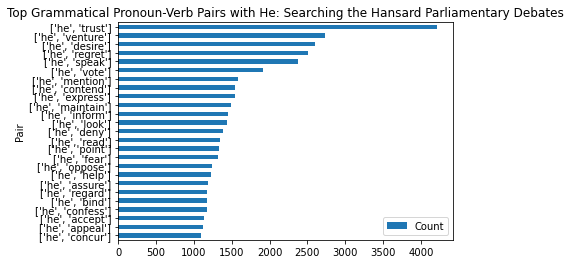

In [28]:
import matplotlib as plt

plt.rcParams['figure.figsize'] = [10, 5]

top_male_pronoun_verb_counts.sort_values(by=['Count'], inplace=True, ascending=True)

top_male_pronoun_verb_counts.plot.barh(x = "Pair", y = "Count",
            title = "Top Grammatical Pronoun-Verb Pairs with He: Searching the Hansard Parliamentary Debates")

We can reiterate the same process outlined above to extract the pronoun she and the verbs in which it relates. The following code defines one new function to extract female pronoun-verb pairs and then calls our already defined functions to render a bar graph of top pairs.

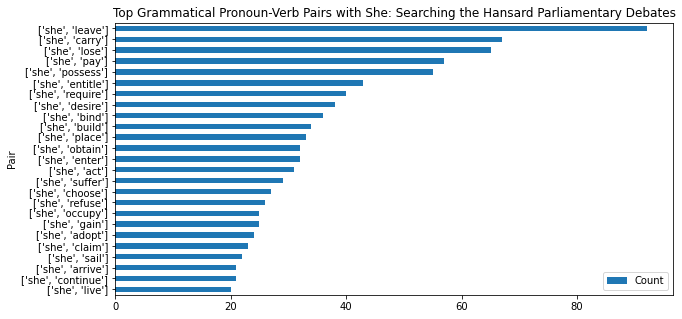

In [29]:
# extract grammatical pronoun-verb pairs where she is subject
def extractFemalePairs(pairs):
    regex = re.compile('she ')
    female = [word for word in lowercase_pairs if regex.match(word)]
    return female

female = extractFemalePairs(lowercase_pairs)

# remove stop words
female_no_stopwords = removeStopWords(female)

# create a dictionary with each unique pair and its frequency
female_dictionary = countWords(female_no_stopwords)

# create a data frame from our dictionary of grammatical pairs
female_pronoun_verb_counts = pd.DataFrame(list(female_dictionary.items()),columns = ['Pair','Count'])

# arrange in ascending order
female_pronoun_verb_counts.sort_values(by=['Count'], inplace=True, ascending=False)

# take a subset of the data
top_female_pronoun_verb_counts = female_pronoun_verb_counts[:25].copy()

# set the parameters of the visualization
plt.rcParams['figure.figsize'] = [10, 5]

# sort the pairs for visualization
top_female_pronoun_verb_counts.sort_values(by=['Count'], inplace=True, ascending=True)

# render visualization
top_female_pronoun_verb_counts.plot.barh(x = "Pair", y = "Count",
            title = "Top Grammatical Pronoun-Verb Pairs with She: Searching the Hansard Parliamentary Debates")

### Discussion

Perhaps the most obvious observation to be made from these plots (but one that is nonetheless important to make) is that we extracted far fewer pairs where she is subject. The top male pronoun-verb pair (without stop words) is stated over 4,000 times, whereas the top female pronoun-verb pair (without stop words) is stated over 80 times.  

One reason for this drastic difference in count is that Parliamentary speakers are men, whereas women may only occasionally be heard. For this reason, the above bar graphs represent the way men describe other men and the way men describe women.

Men describe other men in more dynamic terms. From these pairs, one can see a pensive, agential Parlimentary speaker. With a life of the mind, this man expresses, contents, regrets, opposes, fears, and denies. Gathering information, he reads and looks.

From just the visualizations above it appears that men perceive and rationalize while women act. Women's actions, however, tend to fall within particular categories. She holds (i.e. carry, possess, obtain), she is held (i.e. enter, occupy), and she moves (i.e. sail, arrive). 

These visualizations depict a wholly different gendered experience, and one may also ask why one of the top female pronoun-verb pairs describes women as suffering.

Indeed, our results pose more questions than answers. A more comprehensive study would necessitate reiterating through the process above while asking additional questions. Some insightful questions may include: what verbs relate to the object she? What adjectives modify the noun she? If we treated the above male pronoun-verb pairs as stop words and removed them would we be able to see Parliamentary speakers describe other "male" characteristics, and what would these be?